# **Nikita Ramsey**

**IST 736: Text Mining**

**Homework #5**

# **Introduction:**

For this assignment the focus will be on calculating pair-wise kappa values among student data labelers on Twitter data. The use of kappa values, as well as outside labelers provides valueable practice for obtaining labeled data at scale and reconciling the validity of labels recieved.


We'll start by first loading in the necessary libraries and packages.

In [1]:
pip install seaborn spacy nltk vaderSentiment pandas matplotlib contractions

In [2]:
import os
import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import spacy
from textblob import TextBlob

from collections import Counter
from wordcloud import WordCloud

# **Data:**

This data was collected during a class activity, where tweets obtained from Kaggle were manually labeled by various students in the class. The original dataset have 41 rows and 14 columns, including the Tweets column followed by 13 columns of labels provided by 13 student labelers (including myself). This data set has been subset to include 41 rows and 7 columns including Tweets, GroundTruth (which were labels I created) and the labels from the first 5 student labelers (Labeler1-Labeler5 respectively).


*   Tweets
*   GroundTruth
*   Labeler1
*   Labeler2
*   Labeler3
*   Labeler4
*   Labeler5










In [3]:
# Read in the data
file = "student_scoring_on_tweet_data.csv"
data = pd.read_csv(file)

pd.set_option('display.max_colwidth', None)

In [4]:
# Inspect the data
print(data.head())
data.info()

                                                                                                                                                                                                                                                               TWEETS  \
0  WE FINISHED BORDERLANDS 3 FINALLY YAS! Thank you for hanging out everyone! It was fun. I will try to stream tomorrow but if not I might so some IRL streams while awayu. We shall see. Thank you so much for the raids @mompou_mumpow @MegaMagwitch and @KfdMitch.   
1                  Thank you for hanging up everyone! It was fun. I'll try to get a haircut tomorrow, but if it wasn't for me, some IRL streams would still be in Hawaii. We'll see. Thank you so much for the @ mompou _ mumpow @ MegaMagwife and @ fendMitch raids.   
2                                                      Man Bethesda really needs to fix this dissapointing drops and the new Borderlands 3 It cant be fine to farm bosses on Mayhem 10 to get 1 legendary dro

In [5]:
# Subset data
data = data.iloc[:,0:7]
data.shape
data.head()

,TWEETS,GroungTruth,Labeler1,Labeler 2,Labeler 3,Labeler 4,Labeler 5
0,WE FINISHED BORDERLANDS 3 FINALLY YAS! Thank you for hanging out everyone! It was fun. I will try to stream tomorrow but if not I might so some IRL streams while awayu. We shall see. Thank you so much for the raids @mompou_mumpow @MegaMagwitch and @KfdMitch.,pos,pos,pos,pos,pos,pos
1,"Thank you for hanging up everyone! It was fun. I'll try to get a haircut tomorrow, but if it wasn't for me, some IRL streams would still be in Hawaii. We'll see. Thank you so much for the @ mompou _ mumpow @ MegaMagwife and @ fendMitch raids.",Pos,Positive,Neut,pos,Pos,Pos
2,Man Bethesda really needs to fix this dissapointing drops and the new Borderlands 3 It cant be fine to farm bosses on Mayhem 10 to get 1 legendary drop while anywhere else i get 6-10 drops.. Really sucks...,Neg,Negative,Neg,neg,Neg,Neg
3,Going to finish up Borderlands 2 today. I've got some new commands set up and am looking forward to a good stream! Starting in about am hour!,Neut,Positive,Neut,neu,Pos,Pos
4,I will finish Borderlands 2 today. I have some new commands set up and am looking forward to a good stream! Start in about an hour!,Neut,Positive,Neut,neu,Pos,Pos


Before we turn out attention to identifying pair-wise kappa values, we'll first identify frequent hashtags and handles in the tweets, before doing some intial preprocessing and visualization on the data set.

In [6]:
# Extract hashtags and mentions/handles before cleaning
raw_text = " ". join(data['TWEETS'])

hashtags = re.findall(r"#(\w+)", raw_text)
handles = re.findall(r"@(\w+)", raw_text)

In [7]:
# Count and plot
hashtag_freq = Counter(hashtags).most_common(10)
handle_freq = Counter(handles).most_common(10)

hashtag_df = pd.DataFrame(hashtag_freq, columns=['Hashtag', 'Count'])
handle_df = pd.DataFrame(handle_freq, columns=['Handle', 'Count'])

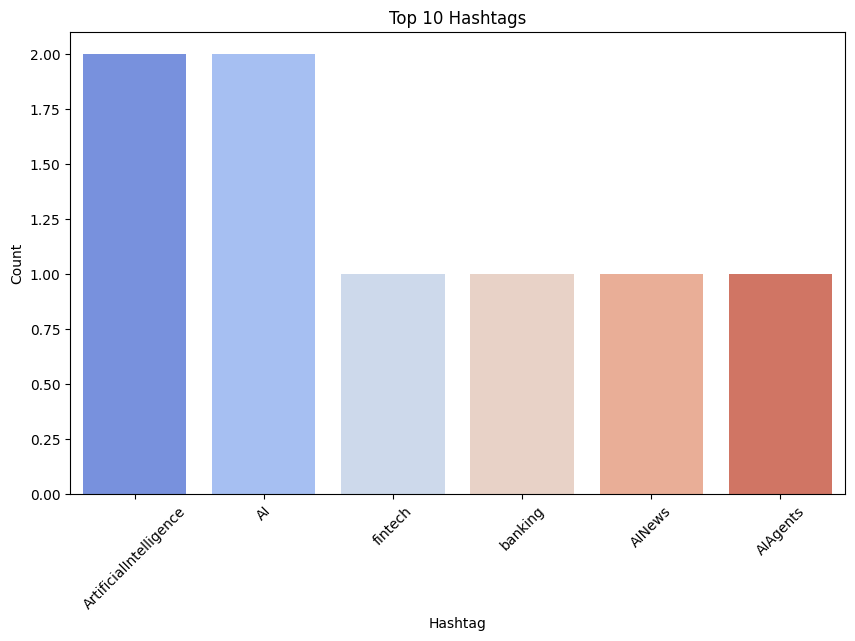

In [8]:
# Plot for hashtags
plt.figure(figsize=(10,6))
sns.barplot(x='Hashtag', y='Count', data=hashtag_df, hue= 'Hashtag', dodge=False, palette='coolwarm')
plt.xlabel('Hashtag')
plt.ylabel('Count')
plt.title('Top 10 Hashtags')
plt.xticks(rotation=45)
plt.show()

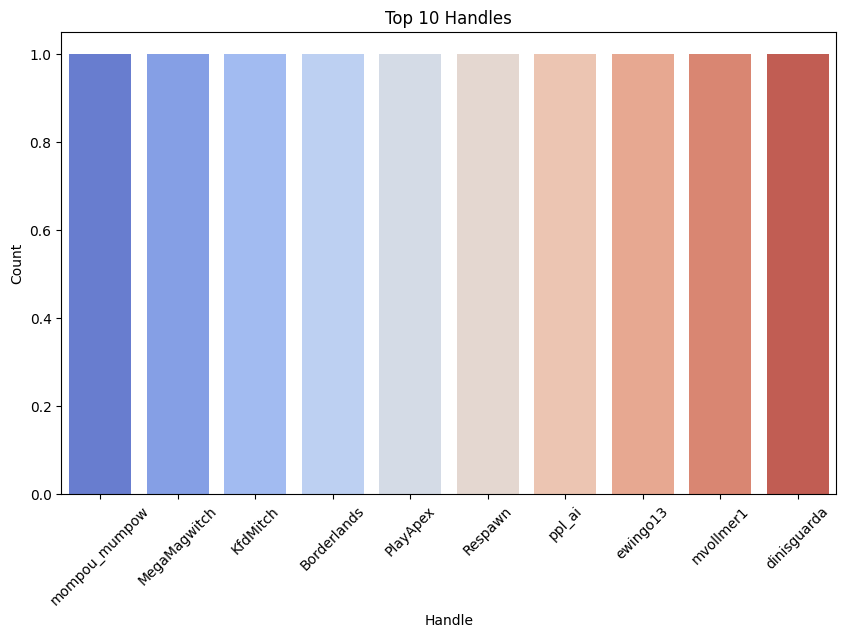

In [9]:
# Plot for hashtags
plt.figure(figsize=(10,6))
sns.barplot(x='Handle', y='Count', data=handle_df, hue= 'Handle', dodge=False, palette='coolwarm')
plt.xlabel('Handle')
plt.ylabel('Count')
plt.title('Top 10 Handles')
plt.xticks(rotation=45)
plt.show()

**Initial Preprocessing**


In [10]:
# Preprocess the tweet data
import contractions

def clean_text(text):
  text = re.sub(r"http\S+|www\S+|https\S+", '', text, flags=re.MULTILINE)  # Remove URLs
  text = re.sub(r'\d+', '', text) # removes numbers
  text = re.sub(r'\@\w+|\#w+', '', text)  # Remove mentions and hashtags
  text = contractions.fix(text) # expands contractions
  text = re.sub(r'[^\w\s]', '', text) # removes special characters
  return text.lower().strip() # convert to lower and remove spaces

In [11]:
# Normalize formatting on labels
def normalize_label(label):
    label = str(label).strip().lower()  # Convert to string, remove spaces, make lowercase
    if label in ["pos", "positive", "p"]:
        return "pos"
    elif label in ["neg", "negative", "n"]:
        return "neg"
    elif label in ["neut", "neutral", "neu"]:
        return "neut"
    else:
        return label  # Keep original if it doesn't match


In [12]:
# Clean the tweet text
data['cleaned_tweets'] = data['TWEETS'].apply(clean_text)

# Compare the cleaned tweets to the tweets to ensure proper preprocessing
data['TWEETS']

,TWEETS
0,WE FINISHED BORDERLANDS 3 FINALLY YAS! Thank you for hanging out everyone! It was fun. I will try to stream tomorrow but if not I might so some IRL streams while awayu. We shall see. Thank you so much for the raids @mompou_mumpow @MegaMagwitch and @KfdMitch.
1,"Thank you for hanging up everyone! It was fun. I'll try to get a haircut tomorrow, but if it wasn't for me, some IRL streams would still be in Hawaii. We'll see. Thank you so much for the @ mompou _ mumpow @ MegaMagwife and @ fendMitch raids."
2,Man Bethesda really needs to fix this dissapointing drops and the new Borderlands 3 It cant be fine to farm bosses on Mayhem 10 to get 1 legendary drop while anywhere else i get 6-10 drops.. Really sucks...
3,Going to finish up Borderlands 2 today. I've got some new commands set up and am looking forward to a good stream! Starting in about am hour!
4,I will finish Borderlands 2 today. I have some new commands set up and am looking forward to a good stream! Start in about an hour!
5,I hate that this easy horrible modifier event on game 10 last forever. That is the best fun iâ€™ve taken in the past until they added them horrible modifiers. @Borderlands please send me the option to play mayhem 10 but turn the modifiers for PLS
6,Grounded almost looked pretty cool even despite the borderlands tier unfunny writing until it became yet another survival crafting game. I really canâ€™t wait for this shitty trend to die
7,Platinum is the best loot the
8,"For some reason, my laptop can run Borderlands 3, War thunder and Warframe all on high settings.. . BUT. . The moment I even try to even launch Csgo my entire computer crashes..."
9,I got to play Jackson 2 with his entire polycule tonight. It was fun completely magical. The happy evening had to end. *sigh*.


In [13]:
# Review the cleaned tweets
data['cleaned_tweets']

,cleaned_tweets
0,we finished borderlands finally yas thank you for hanging out everyone it was fun i will try to stream tomorrow but if not i might so some irl streams while awayu we shall see thank you so much for the raids and
1,thank you for hanging up everyone it was fun i will try to get a haircut tomorrow but if it was not for me some irl streams would still be in hawaii we will see thank you so much for the mompou _ mumpow megamagwife and fendmitch raids
2,man bethesda really needs to fix this dissapointing drops and the new borderlands it cannot be fine to farm bosses on mayhem to get legendary drop while anywhere else i get drops really sucks
3,going to finish up borderlands today i have got some new commands set up and am looking forward to a good stream starting in about am hour
4,i will finish borderlands today i have some new commands set up and am looking forward to a good stream start in about an hour
5,i hate that this easy horrible modifier event on game last forever that is the best fun iâve taken in the past until they added them horrible modifiers please send me the option to play mayhem but turn the modifiers for pls
6,grounded almost looked pretty cool even despite the borderlands tier unfunny writing until it became yet another survival crafting game i really canât wait for this shitty trend to die
7,platinum is the best loot the
8,for some reason my laptop can run borderlands war thunder and warframe all on high settings but the moment i even try to even launch csgo my entire computer crashes
9,i got to play jackson with his entire polycule tonight it was fun completely magical the happy evening had to end sigh


In [14]:
# Review data
data.head()

,TWEETS,GroungTruth,Labeler1,Labeler 2,Labeler 3,Labeler 4,Labeler 5,cleaned_tweets
0,WE FINISHED BORDERLANDS 3 FINALLY YAS! Thank you for hanging out everyone! It was fun. I will try to stream tomorrow but if not I might so some IRL streams while awayu. We shall see. Thank you so much for the raids @mompou_mumpow @MegaMagwitch and @KfdMitch.,pos,pos,pos,pos,pos,pos,we finished borderlands finally yas thank you for hanging out everyone it was fun i will try to stream tomorrow but if not i might so some irl streams while awayu we shall see thank you so much for the raids and
1,"Thank you for hanging up everyone! It was fun. I'll try to get a haircut tomorrow, but if it wasn't for me, some IRL streams would still be in Hawaii. We'll see. Thank you so much for the @ mompou _ mumpow @ MegaMagwife and @ fendMitch raids.",Pos,Positive,Neut,pos,Pos,Pos,thank you for hanging up everyone it was fun i will try to get a haircut tomorrow but if it was not for me some irl streams would still be in hawaii we will see thank you so much for the mompou _ mumpow megamagwife and fendmitch raids
2,Man Bethesda really needs to fix this dissapointing drops and the new Borderlands 3 It cant be fine to farm bosses on Mayhem 10 to get 1 legendary drop while anywhere else i get 6-10 drops.. Really sucks...,Neg,Negative,Neg,neg,Neg,Neg,man bethesda really needs to fix this dissapointing drops and the new borderlands it cannot be fine to farm bosses on mayhem to get legendary drop while anywhere else i get drops really sucks
3,Going to finish up Borderlands 2 today. I've got some new commands set up and am looking forward to a good stream! Starting in about am hour!,Neut,Positive,Neut,neu,Pos,Pos,going to finish up borderlands today i have got some new commands set up and am looking forward to a good stream starting in about am hour
4,I will finish Borderlands 2 today. I have some new commands set up and am looking forward to a good stream! Start in about an hour!,Neut,Positive,Neut,neu,Pos,Pos,i will finish borderlands today i have some new commands set up and am looking forward to a good stream start in about an hour


In [15]:
# Apply normalization to all columns except 'TWEETS'
label_columns = data.columns[1:7]  # Select all columns except 'TWEETS'
data[label_columns] = data[label_columns].applymap(normalize_label)

# Display cleaned dataframe
data.head()

<ipython-input-15-c4a859c02a9a>:3: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  data[label_columns] = data[label_columns].applymap(normalize_label)


,TWEETS,GroungTruth,Labeler1,Labeler 2,Labeler 3,Labeler 4,Labeler 5,cleaned_tweets
0,WE FINISHED BORDERLANDS 3 FINALLY YAS! Thank you for hanging out everyone! It was fun. I will try to stream tomorrow but if not I might so some IRL streams while awayu. We shall see. Thank you so much for the raids @mompou_mumpow @MegaMagwitch and @KfdMitch.,pos,pos,pos,pos,pos,pos,we finished borderlands finally yas thank you for hanging out everyone it was fun i will try to stream tomorrow but if not i might so some irl streams while awayu we shall see thank you so much for the raids and
1,"Thank you for hanging up everyone! It was fun. I'll try to get a haircut tomorrow, but if it wasn't for me, some IRL streams would still be in Hawaii. We'll see. Thank you so much for the @ mompou _ mumpow @ MegaMagwife and @ fendMitch raids.",pos,pos,neut,pos,pos,pos,thank you for hanging up everyone it was fun i will try to get a haircut tomorrow but if it was not for me some irl streams would still be in hawaii we will see thank you so much for the mompou _ mumpow megamagwife and fendmitch raids
2,Man Bethesda really needs to fix this dissapointing drops and the new Borderlands 3 It cant be fine to farm bosses on Mayhem 10 to get 1 legendary drop while anywhere else i get 6-10 drops.. Really sucks...,neg,neg,neg,neg,neg,neg,man bethesda really needs to fix this dissapointing drops and the new borderlands it cannot be fine to farm bosses on mayhem to get legendary drop while anywhere else i get drops really sucks
3,Going to finish up Borderlands 2 today. I've got some new commands set up and am looking forward to a good stream! Starting in about am hour!,neut,pos,neut,neut,pos,pos,going to finish up borderlands today i have got some new commands set up and am looking forward to a good stream starting in about am hour
4,I will finish Borderlands 2 today. I have some new commands set up and am looking forward to a good stream! Start in about an hour!,neut,pos,neut,neut,pos,pos,i will finish borderlands today i have some new commands set up and am looking forward to a good stream start in about an hour


**Exploratory Data Analysis**

Here we'll look at the distribution of text lengths, word counts, average word lengths, polarity,  in addition to creating unigram WordClouds.

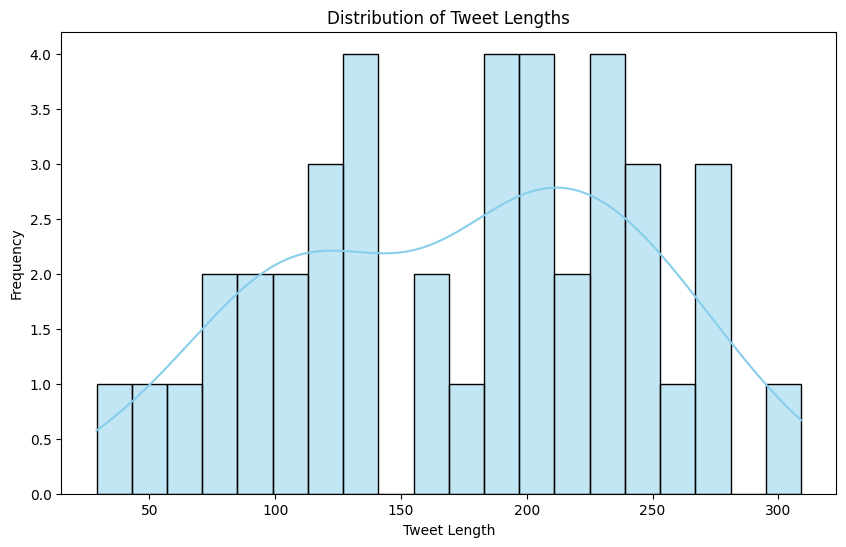

In [20]:
# Text Length Distribution
data['tweet_lengths'] = data['cleaned_tweets'].apply(len)

plt.figure(figsize=(10,6))
sns.histplot(data['tweet_lengths'], bins=20, kde=True, color='skyblue')
plt.xlabel('Tweet Length')
plt.ylabel('Frequency')
plt.title('Distribution of Tweet Lengths')
plt.show()

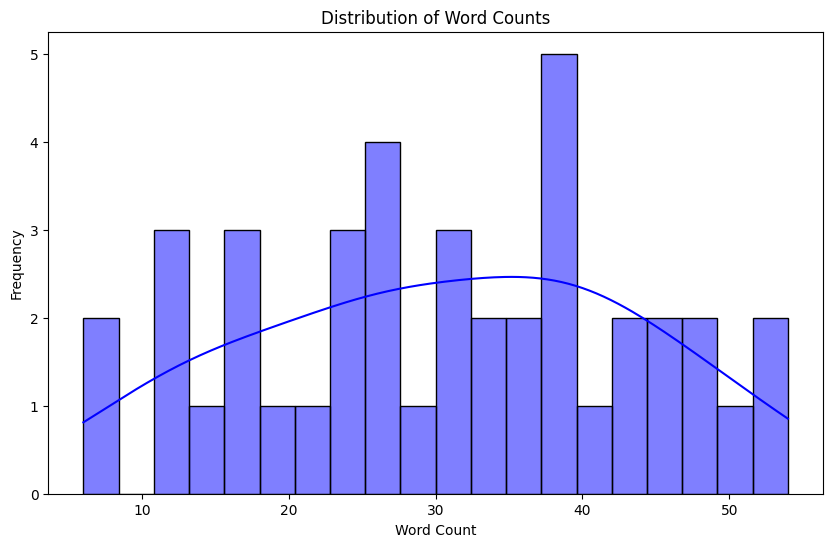

In [21]:
# Word Count Distribution
data['word_counts'] = data['cleaned_tweets'].apply(lambda x: len(x.split()))

plt.figure(figsize=(10,6))
sns.histplot(data['word_counts'], bins=20, kde=True, color='blue')
plt.title('Distribution of Word Counts')
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.show()

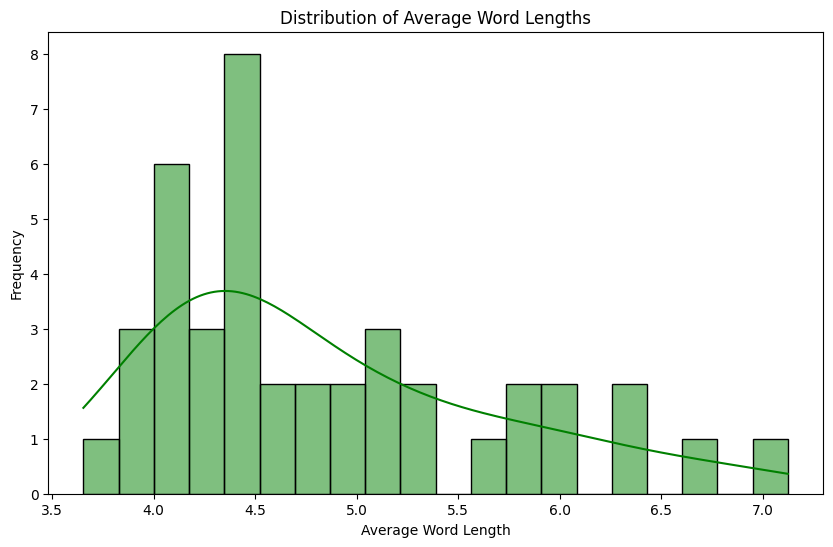

In [22]:
# Average Word Length
data['avg_word_length'] = data['cleaned_tweets'].apply(lambda x: np.mean([len(word) for word in x.split()]))

plt.figure(figsize=(10,6))
sns.histplot(data['avg_word_length'], bins=20, kde=True, color='green')
plt.title('Distribution of Average Word Lengths')
plt.xlabel('Average Word Length')
plt.ylabel('Frequency')
plt.show()

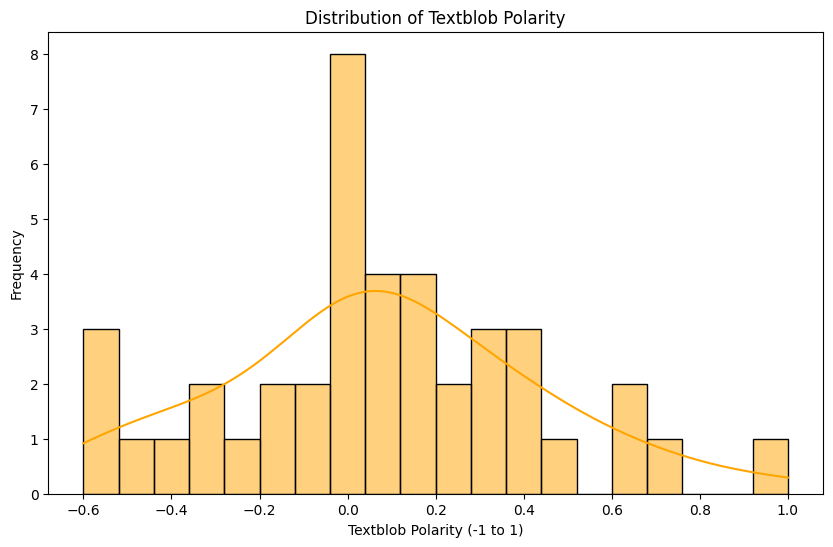

In [25]:
# Textblob Polarity
data['textblob_polarity'] = data['cleaned_tweets'].apply(lambda x: TextBlob(x).sentiment.polarity)

plt.figure(figsize=(10,6))
sns.histplot(data['textblob_polarity'], bins=20, kde=True, color='orange')
plt.title('Distribution of Textblob Polarity')
plt.xlabel('Textblob Polarity (-1 to 1)')
plt.ylabel('Frequency')
plt.show()

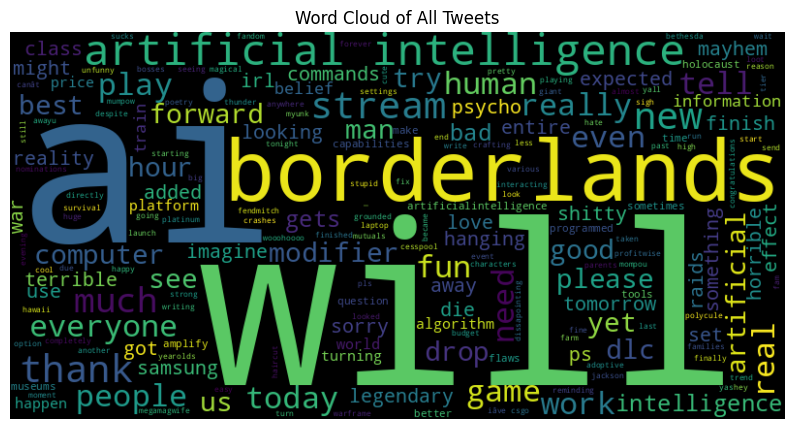

In [28]:
# Wordclouds
all_text = ' '.join(data['cleaned_tweets'])
wordcloud = WordCloud(width=800, height=400, background_color='black', colormap='viridis').generate(all_text)

plt.figure(figsize=(10,6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of All Tweets')
plt.show()

In [29]:
# Load Spacy for additional preprocessing for frequencies
nlp = spacy.load('en_core_web_sm')

# Custom tokenizer for text preprocessing for wc
def preprocess_text_for_wordcloud(text):
  doc = nlp(text.lower())
  return [token for token in doc if not token.is_stop]

In [31]:
# Preprocess all text and calculate word frequencies
data['wc_processed_tweets'] = data['cleaned_tweets'].apply(preprocess_text_for_wordcloud)
word_freq = Counter([token.text for tokens in data['wc_processed_tweets'] for token in tokens])
word_freq

Counter({'finished': 1,
         'borderlands': 13,
         ' ': 24,
         'finally': 1,
         'yas': 1,
         'thank': 6,
         'hanging': 2,
         'fun': 4,
         'try': 3,
         'stream': 4,
         'tomorrow': 2,
         'irl': 2,
         'streams': 2,
         'awayu': 1,
         'shall': 1,
         'raids': 2,
         '  ': 2,
         'haircut': 1,
         'hawaii': 1,
         'mompou': 1,
         '_': 1,
         'mumpow': 1,
         'megamagwife': 1,
         'fendmitch': 1,
         'man': 3,
         'bethesda': 1,
         'needs': 1,
         'fix': 1,
         'dissapointing': 1,
         'drops': 2,
         'new': 6,
         'fine': 1,
         'farm': 1,
         'bosses': 1,
         'mayhem': 2,
         'legendary': 2,
         'drop': 1,
         'sucks': 1,
         'going': 1,
         'finish': 2,
         'today': 4,
         'got': 2,
         'commands': 2,
         'set': 2,
         'looking': 2,
         'forward': 3,
     

In [32]:
# Sort and print word frequencies from most to least
sorted_word_freq = word_freq.most_common()
for word, freq in sorted_word_freq:
  print(f'{word}: {freq}')

 : 24
ai: 14
borderlands: 13
artificial: 11
intelligence: 11
thank: 6
new: 6
fun: 4
stream: 4
today: 4
play: 4
real: 4
people: 4
like: 4
human: 4
try: 3
man: 3
forward: 3
good: 3
best: 3
computer: 3
need: 3
dlc: 3
tell: 3
work: 3
gets: 3
bad: 3
hanging: 2
tomorrow: 2
irl: 2
streams: 2
raids: 2
  : 2
drops: 2
mayhem: 2
legendary: 2
finish: 2
got: 2
commands: 2
set: 2
looking: 2
hour: 2
horrible: 2
game: 2
added: 2
modifiers: 2
shitty: 2
die: 2
entire: 2
expected: 2
sorry: 2
games: 2
love: 2
having: 2
terrible: 2
away: 2
reality: 2
ps: 2
samsung: 2
psycho: 2
imagine: 2
class: 2
use: 2
information: 2
price: 2
world: 2
turning: 2
artificialintelligence: 2
flaws: 2
time: 2
better: 2
museums: 2
holocaust: 2
tools: 2
amplify: 2
capabilities: 2
programmed: 2
finished: 1
finally: 1
yas: 1
awayu: 1
shall: 1
haircut: 1
hawaii: 1
mompou: 1
_: 1
mumpow: 1
megamagwife: 1
fendmitch: 1
bethesda: 1
needs: 1
fix: 1
dissapointing: 1
fine: 1
farm: 1
bosses: 1
drop: 1
sucks: 1
going: 1
starting: 1
start: 1

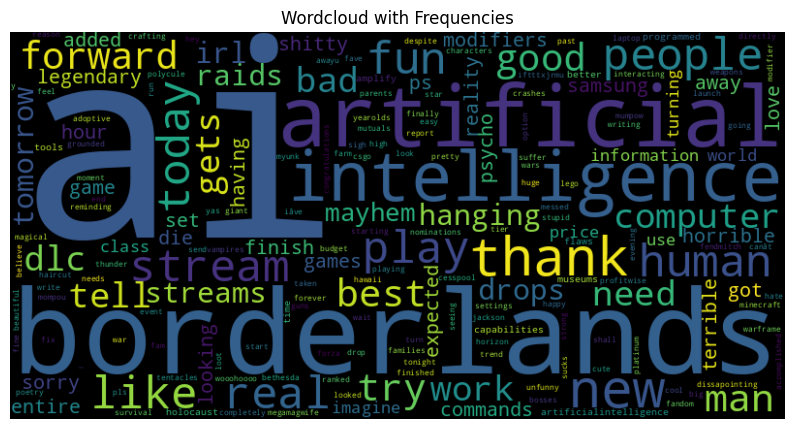

In [33]:
# Wordcloud with Frequencies
wordcloud_frequencies = WordCloud(width=800, height=400, background_color='black', colormap='viridis').generate_from_frequencies(word_freq)

plt.figure(figsize=(10,6))
plt.imshow(wordcloud_frequencies, interpolation= 'bilinear')
plt.axis('off')
plt.title('Wordcloud with Frequencies')
plt.show()

# **Experimental Design:**

For this particular assignment, I opted to utilize the peer-labeled tweet data set, as it was readily available and had numerous labelers available. Because this was done in class, each student labeled each tweet in the subset dataset as part of the class activity over about 15 minutes (no monetary compensation was provided). For this activity, the labelers needed to be proficient in English but had no additional requirements such as location or previous work performance. I believe utilizing the student labelers in this capacity is the best option, as it's free and minimizes the potenital of spam labelers.

**Calcuate Kappa Scores between Labelers**

In [48]:
from sklearn.metrics import cohen_kappa_score

# Calculate pair-wise Kappa values between each labeler
# Calculate kappa value for Labeler1 and Labeler2
k_1_and_2 = cohen_kappa_score(data['Labeler1'], data['Labeler 2'])
print(k_1_and_2)

# Calculate kappa value for Labeler1 and Labeler3
k_1_and_3 = cohen_kappa_score(data['Labeler1'], data['Labeler 3'])
print(k_1_and_3)

# Calculate kappa value for Labeler1 and Labeler4
k_1_and_4 = cohen_kappa_score(data['Labeler1'], data['Labeler 4'])
print(k_1_and_4)

# Calculate kappa value for Labeler1 and Labeler5
k_1_and_5 = cohen_kappa_score(data['Labeler1'], data['Labeler 5'])
print(k_1_and_5)

0.3761622992392224
0.5401207937877481
0.6440972222222222
0.5691768826619965


In [47]:
# Calculate average kappa between labelers and Labeler5
avg_k_for_1 = (k_1_and_2 + k_1_and_3 + k_1_and_4 + k_1_and_5) / 4
print(avg_k_for_1)

0.5323892994777973


In [39]:
# Calculate pair-wise Kappa values between each labeler
# Calculate kappa value for Labeler2 and Labeler1
k_2_and_1 = cohen_kappa_score(data['Labeler 2'], data['Labeler1'])
print(k_2_and_1)

# Calculate kappa value for Labeler2 and Labeler3
k_2_and_3 = cohen_kappa_score(data['Labeler 2'], data['Labeler 3'])
print(k_2_and_3)

# Calculate kappa value for Labeler2 and Labeler4
k_2_and_4 = cohen_kappa_score(data['Labeler 2'], data['Labeler 4'])
print(k_2_and_4)

# Calculate kappa value for Labeler2 and Labeler5
k_2_and_5 = cohen_kappa_score(data['Labeler 2'], data['Labeler 5'])
print(k_2_and_5)

0.3761622992392223
0.442429737080689
0.3948339483394834
0.28532110091743124


In [49]:
# Calculate average kappa between labelers and Labeler5
avg_k_for_2 = (k_2_and_1 + k_2_and_3 + k_2_and_4 + k_2_and_5) / 4
print(avg_k_for_2)

0.3746867713942065


In [40]:
# Calculate pair-wise Kappa values between each labeler
# Calculate kappa value for Labeler3 and Labeler1
k_3_and_1 = cohen_kappa_score(data['Labeler 3'], data['Labeler1'])
print(k_3_and_1)

# Calculate kappa value for Labeler3 and Labeler2
k_3_and_2 = cohen_kappa_score(data['Labeler 3'], data['Labeler 2'])
print(k_3_and_2)

# Calculate kappa value for Labeler3 and Labeler4
k_3_and_4 = cohen_kappa_score(data['Labeler 3'], data['Labeler 4'])
print(k_3_and_4)

# Calculate kappa value for Labeler3 and Labeler5
k_3_and_5 = cohen_kappa_score(data['Labeler 3'], data['Labeler 5'])
print(k_3_and_5)

0.540120793787748
0.442429737080689
0.5477941176470589
0.660220994475138


In [50]:
# Calculate average kappa between labelers and Labeler5
avg_k_for_3 = (k_3_and_1 + k_3_and_2 + k_3_and_4 + k_3_and_5) / 4
print(avg_k_for_3)

0.5476414107476585


In [52]:
# Calculate pair-wise Kappa values between each labeler
# Calculate kappa value for Labeler4 and Labeler1
k_4_and_1 = cohen_kappa_score(data['Labeler 4'], data['Labeler1'])
print(k_4_and_1)

# Calculate kappa value for Labeler4 and Labeler2
k_4_and_2 = cohen_kappa_score(data['Labeler 4'], data['Labeler 2'])
print(k_4_and_2)

# Calculate kappa value for Labeler4 and Labeler3
k_4_and_3 = cohen_kappa_score(data['Labeler 4'], data['Labeler 3'])
print(k_4_and_3)

# Calculate kappa value for Labeler4 and Labeler5
k_4_and_5 = cohen_kappa_score(data['Labeler 4'], data['Labeler 5'])
print(k_4_and_5)

0.6440972222222221
0.3948339483394834
0.5477941176470589
0.6554621848739497


In [53]:
# Calculate average kappa between labelers and Labeler5
avg_k_for_4 = (k_4_and_1 + k_4_and_2 + k_4_and_3 + k_4_and_5) / 4
print(avg_k_for_4)

0.5605468682706785


In [43]:
# Calculate pair-wise Kappa values between each labeler
# Calculate kappa value for Labeler5 and Labeler1
k_5_and_1 = cohen_kappa_score(data['Labeler 5'], data['Labeler1'])
print(k_5_and_1)

# Calculate kappa value for Labeler5 and Labeler2
k_5_and_2 = cohen_kappa_score(data['Labeler 5'], data['Labeler 2'])
print(k_5_and_2)

# Calculate kappa value for Labeler5 and Labeler3
k_5_and_3 = cohen_kappa_score(data['Labeler 5'], data['Labeler 3'])
print(k_5_and_3)

# Calculate kappa value for Labeler5 and Labeler4
k_5_and_4 = cohen_kappa_score(data['Labeler 5'], data['Labeler 4'])
print(k_5_and_4)

0.5691768826619965
0.28532110091743124
0.660220994475138
0.6554621848739497


In [54]:
# Calculate average kappa between labelers and Labeler5
avg_k_for_5 = (k_5_and_1 + k_5_and_2 + k_5_and_3 + k_5_and_4) / 4
print(avg_k_for_5)

0.5425452907321289


**Calcuate Kappa Scores between Ground Truth and Labelers**

In [45]:
# Calculate pair-wise Kappa values between ground truth and labelers
# Calculate kappa value for ground truth and Labeler1
k_gt_and_1 = cohen_kappa_score(data['GroungTruth'], data['Labeler1'])
print(k_gt_and_1)

# Calculate kappa value for ground truth and Labeler2
k_gt_and_2 = cohen_kappa_score(data['GroungTruth'], data['Labeler 2'])
print(k_gt_and_2)

# Calculate kappa value for ground truth and Labeler3
k_gt_and_3 = cohen_kappa_score(data['GroungTruth'], data['Labeler 3'])
print(k_gt_and_3)

# Calculate kappa value for ground truth and Labeler4
k_gt_and_4 = cohen_kappa_score(data['GroungTruth'], data['Labeler 4'])
print(k_gt_and_4)

# Calculate kappa value for ground truth and Labeler5
k_gt_and_5 = cohen_kappa_score(data['GroungTruth'], data['Labeler 5'])
print(k_gt_and_5)

0.5944244604316546
0.3339350180505415
0.7722222222222223
0.5393258426966292
0.7289896128423041


In [55]:
# Calculate average kappa between labelers and ground truth
avg_k_for_gt = (k_gt_and_1 + k_gt_and_2 + k_gt_and_3 + k_gt_and_4+ k_gt_and_5) / 5
print(avg_k_for_gt)

0.5937794312486704


# **Results:**

Based on the pair-wise Kappa score comparison between all of the labelers, the average pair wise Kappa score was .51, while the average pair-wise kappa for the Ground truth compared to the labelers was slightly higher at .59. Overall, the labels appeared to agree the most with the ground truth, which is the desired outcome, when confirming the validity of the labeling.

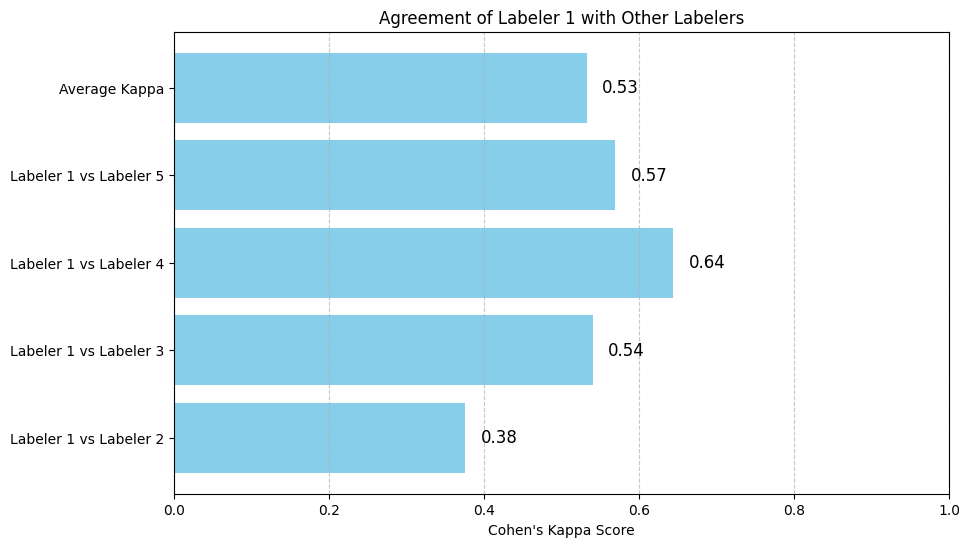

In [58]:
# Store Kappa values in a dictionary
kappa_values = {
    "Labeler 1 vs Labeler 2": k_1_and_2,
    "Labeler 1 vs Labeler 3": k_1_and_3,
    "Labeler 1 vs Labeler 4": k_1_and_4,
    "Labeler 1 vs Labeler 5": k_1_and_5,
    "Average Kappa": avg_k_for_1
}

# Create a bar plot
plt.figure(figsize=(10, 6))
plt.barh(list(kappa_values.keys()), list(kappa_values.values()), color='skyblue')

# Annotate each bar with the kappa score
for index, value in enumerate(kappa_values.values()):
    plt.text(value + 0.02, index, f"{value:.2f}", va='center', fontsize=12)

# Formatting the plot
plt.xlabel("Cohen's Kappa Score")
plt.title("Agreement of Labeler 1 with Other Labelers")
plt.xlim(0, 1)  # Kappa score ranges from -1 to 1, but typically between 0 and 1
plt.grid(axis='x', linestyle='--', alpha=0.7)

# Show the plot
plt.show()

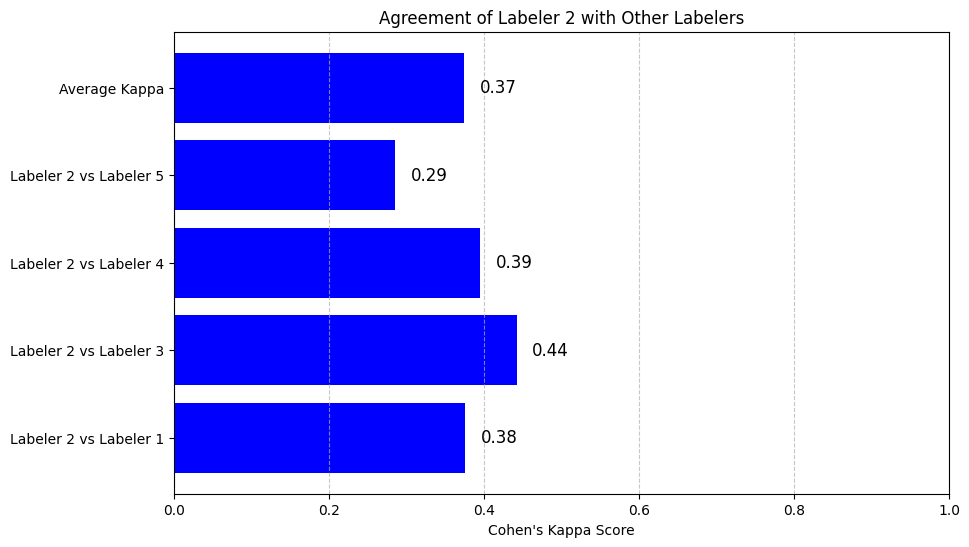

In [57]:
# Store Kappa values in a dictionary
kappa_values = {
    "Labeler 2 vs Labeler 1": k_2_and_1,
    "Labeler 2 vs Labeler 3": k_2_and_3,
    "Labeler 2 vs Labeler 4": k_2_and_4,
    "Labeler 2 vs Labeler 5": k_2_and_5,
    "Average Kappa": avg_k_for_2
}

# Create a bar plot
plt.figure(figsize=(10, 6))
plt.barh(list(kappa_values.keys()), list(kappa_values.values()), color='blue')

# Annotate each bar with the kappa score
for index, value in enumerate(kappa_values.values()):
    plt.text(value + 0.02, index, f"{value:.2f}", va='center', fontsize=12)

# Formatting the plot
plt.xlabel("Cohen's Kappa Score")
plt.title("Agreement of Labeler 2 with Other Labelers")
plt.xlim(0, 1)  # Kappa score ranges from -1 to 1, but typically between 0 and 1
plt.grid(axis='x', linestyle='--', alpha=0.7)

# Show the plot
plt.show()

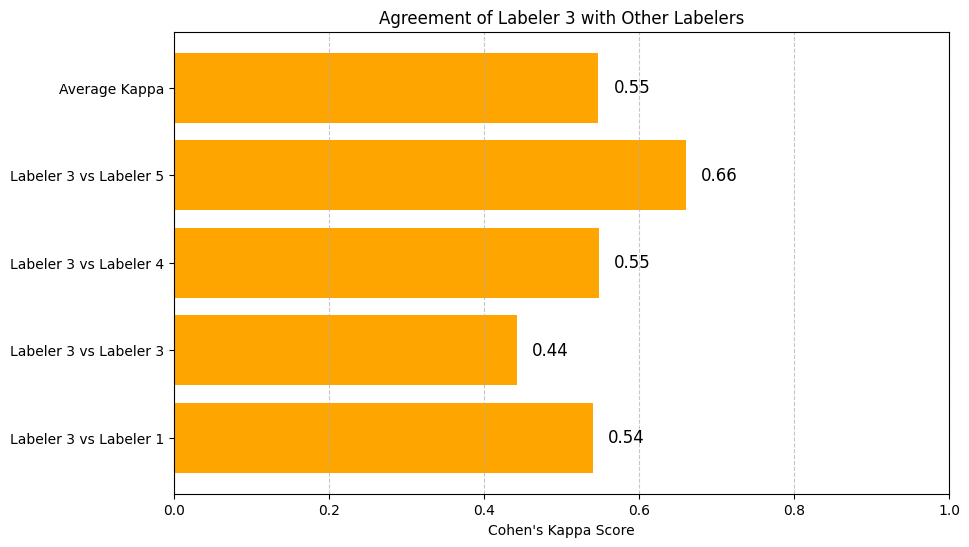

In [59]:
# Store Kappa values in a dictionary
kappa_values = {
    "Labeler 3 vs Labeler 1": k_3_and_1,
    "Labeler 3 vs Labeler 3": k_3_and_2,
    "Labeler 3 vs Labeler 4": k_3_and_4,
    "Labeler 3 vs Labeler 5": k_3_and_5,
    "Average Kappa": avg_k_for_3
}

# Create a bar plot
plt.figure(figsize=(10, 6))
plt.barh(list(kappa_values.keys()), list(kappa_values.values()), color='orange')

# Annotate each bar with the kappa score
for index, value in enumerate(kappa_values.values()):
    plt.text(value + 0.02, index, f"{value:.2f}", va='center', fontsize=12)

# Formatting the plot
plt.xlabel("Cohen's Kappa Score")
plt.title("Agreement of Labeler 3 with Other Labelers")
plt.xlim(0, 1)  # Kappa score ranges from -1 to 1, but typically between 0 and 1
plt.grid(axis='x', linestyle='--', alpha=0.7)

# Show the plot
plt.show()

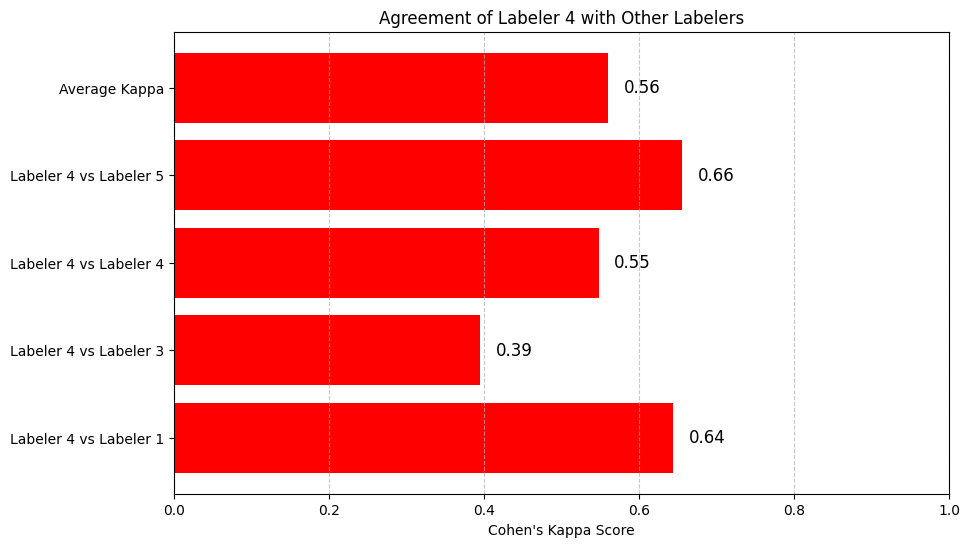

In [65]:
# Store Kappa values in a dictionary
kappa_values = {
    "Labeler 4 vs Labeler 1": k_4_and_1,
    "Labeler 4 vs Labeler 3": k_4_and_2,
    "Labeler 4 vs Labeler 4": k_4_and_3,
    "Labeler 4 vs Labeler 5": k_4_and_5,
    "Average Kappa": avg_k_for_4
}

# Create a bar plot
plt.figure(figsize=(10, 6))
plt.barh(list(kappa_values.keys()), list(kappa_values.values()), color='red')

# Annotate each bar with the kappa score
for index, value in enumerate(kappa_values.values()):
    plt.text(value + 0.02, index, f"{value:.2f}", va='center', fontsize=12)

# Formatting the plot
plt.xlabel("Cohen's Kappa Score")
plt.title("Agreement of Labeler 4 with Other Labelers")
plt.xlim(0, 1)  # Kappa score ranges from -1 to 1, but typically between 0 and 1
plt.grid(axis='x', linestyle='--', alpha=0.7)

# Show the plot
plt.show()

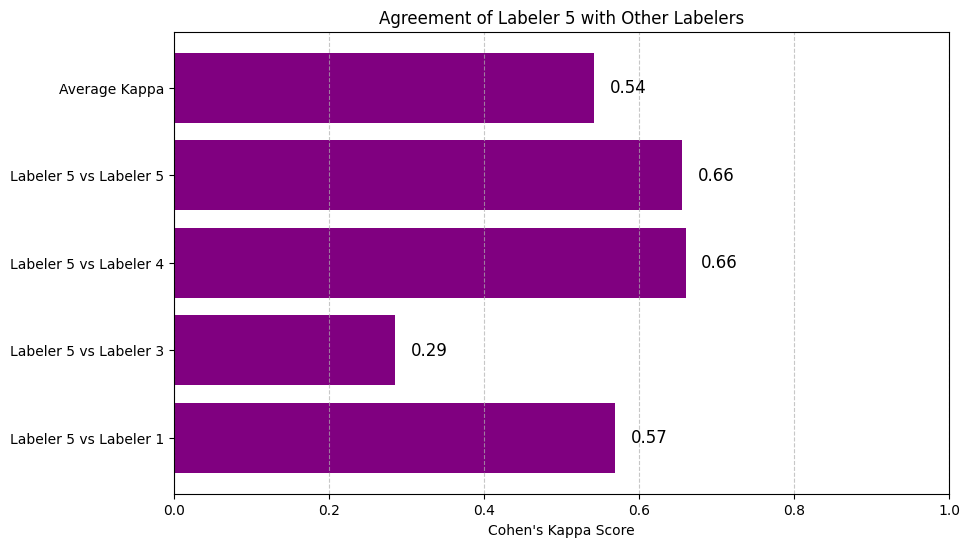

In [66]:
# Store Kappa values in a dictionary
kappa_values = {
    "Labeler 5 vs Labeler 1": k_5_and_1,
    "Labeler 5 vs Labeler 3": k_5_and_2,
    "Labeler 5 vs Labeler 4": k_5_and_3,
    "Labeler 5 vs Labeler 5": k_5_and_4,
    "Average Kappa": avg_k_for_5
}

# Create a bar plot
plt.figure(figsize=(10, 6))
plt.barh(list(kappa_values.keys()), list(kappa_values.values()), color='purple')

# Annotate each bar with the kappa score
for index, value in enumerate(kappa_values.values()):
    plt.text(value + 0.02, index, f"{value:.2f}", va='center', fontsize=12)

# Formatting the plot
plt.xlabel("Cohen's Kappa Score")
plt.title("Agreement of Labeler 5 with Other Labelers")
plt.xlim(0, 1)  # Kappa score ranges from -1 to 1, but typically between 0 and 1
plt.grid(axis='x', linestyle='--', alpha=0.7)

# Show the plot
plt.show()

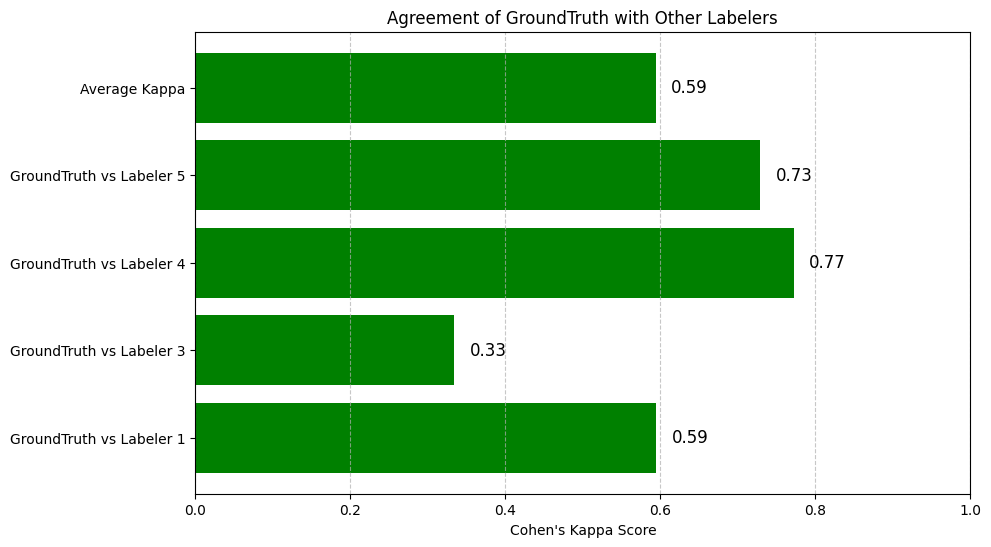

In [63]:
# Store Kappa values in a dictionary
kappa_values = {
    "GroundTruth vs Labeler 1": k_gt_and_1,
    "GroundTruth vs Labeler 3": k_gt_and_2,
    "GroundTruth vs Labeler 4": k_gt_and_3,
    "GroundTruth vs Labeler 5": k_gt_and_4,
    "GroundTruth vs Labeler 5": k_gt_and_5,
    "Average Kappa": avg_k_for_gt
}

# Create a bar plot
plt.figure(figsize=(10, 6))
plt.barh(list(kappa_values.keys()), list(kappa_values.values()), color='green')

# Annotate each bar with the kappa score
for index, value in enumerate(kappa_values.values()):
    plt.text(value + 0.02, index, f"{value:.2f}", va='center', fontsize=12)

# Formatting the plot
plt.xlabel("Cohen's Kappa Score")
plt.title("Agreement of GroundTruth with Other Labelers")
plt.xlim(0, 1)  # Kappa score ranges from -1 to 1, but typically between 0 and 1
plt.grid(axis='x', linestyle='--', alpha=0.7)

# Show the plot
plt.show()

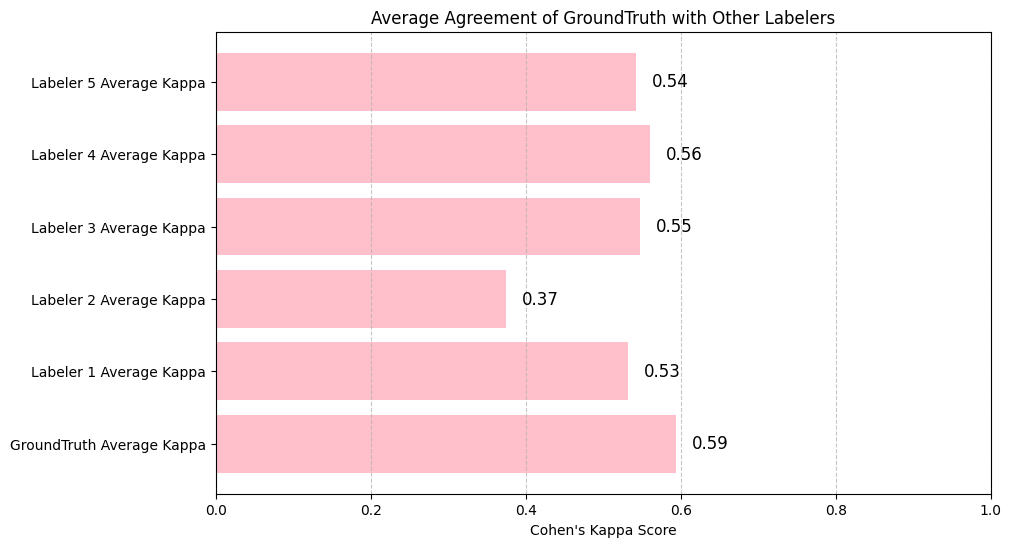

In [64]:
# Store Kappa values in a dictionary
kappa_values = {
    "GroundTruth Average Kappa": avg_k_for_gt,
    "Labeler 1 Average Kappa": avg_k_for_1,
    "Labeler 2 Average Kappa": avg_k_for_2,
    "Labeler 3 Average Kappa": avg_k_for_3,
    "Labeler 4 Average Kappa": avg_k_for_4,
    "Labeler 5 Average Kappa": avg_k_for_5
}

# Create a bar plot
plt.figure(figsize=(10, 6))
plt.barh(list(kappa_values.keys()), list(kappa_values.values()), color='pink')

# Annotate each bar with the kappa score
for index, value in enumerate(kappa_values.values()):
    plt.text(value + 0.02, index, f"{value:.2f}", va='center', fontsize=12)

# Formatting the plot
plt.xlabel("Cohen's Kappa Score")
plt.title("Average Agreement of GroundTruth with Other Labelers")
plt.xlim(0, 1)  # Kappa score ranges from -1 to 1, but typically between 0 and 1
plt.grid(axis='x', linestyle='--', alpha=0.7)

# Show the plot
plt.show()

# **Conclusion:**

Though I didn't utilize AMT for this assignment, I do think that crowd sourcing the labeling of training data makes a lot of sense in terms of energy, cost and efficiency. One does need to be mindful that a smaller pool of labelers can deterimentally impact the desired alignment of labels against the ground truth, as lower Kappa scores would likely eliminate certain labelers from being included in the final kappa comparison that would dictate final label confirmation. I will definitely be utilizing the pair-wise Kappa score to judge the agreement and validity of crowd-sourced labeled data moving forward.

In [ ]:
# Creating HTML file in colab

%%shell
jupyter nbconvert --to html /content/Nikita_Ramsey_Week5_HW.ipynb